# Anagram solver

[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/nihcompmed/fem/master?filepath=doc%2Fnotebooks%2Fdiscrete%2F02_anagram_solver.ipynb)

In this example, we train a model to predict a missing letter in a 10-letter word. We then use the natural definition of energy in the model to solve anagrams by descending the energy function. We use a data set of words that were scraped from news sites, blogs, and Twitter.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fem, os, time, pickle
data_dir = '../../../data/words'
print 'number of threads: %i' % (fem.fortran_module.fortran_module.num_threads(),)
cache = True

number of threads: 8


We load the word data into to the `words` then select a sample of the words in the variabel `x` to train the model.

In [2]:
# load word data
n = 10
words = np.loadtxt(os.path.join(data_dir, '%02i.txt' % (n,)), dtype='U%i' % (n,))

# select a sample of words and separate into array of letters
l = int(1e6)
words_sample = np.random.choice(words, size=l, replace=False)
x = np.array([np.array(list(word)) for word in words_sample]).T
print 'word length: %i, number of words: %i' % x.shape

word length: 10, number of words: 1000000


Next, we create a model `model` and fit it to the word sample using `model.fit(x, ...)`.

We plot the model parameter $W$ heat map and the running discrepancies calculuated during the fit below.

loaded cached model


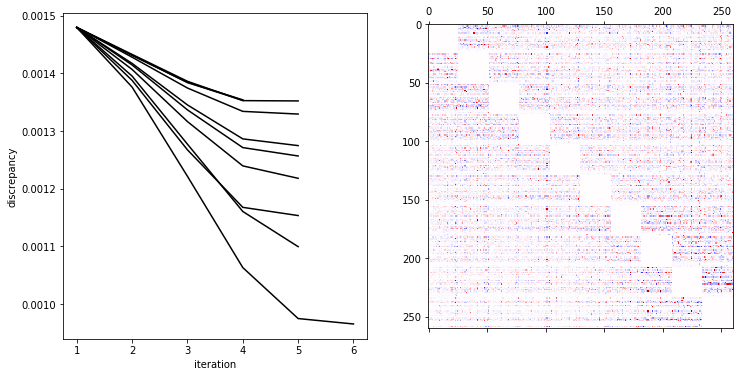

In [3]:
model_file = os.path.join(data_dir, '%02i.pkl' % (n,))
if cache and os.path.exists(model_file):
    with open(model_file, 'r') as f:
        model = pickle.load(f)
    print 'loaded cached model'
else:
    model = fem.discrete.model()
    start = time.time()
    model.fit(x, overfit=False, svd='exact')
    end = time.time()
    print 'fit time: %.02f minutes' % ((end-start)/60.,)
    with open(model_file, 'w') as f:
        pickle.dump(model, f)
        
fig, ax = plt.subplots(1, 2, figsize=(12,6))
for d in model.disc:
    ax[0].plot(1+np.arange(len(d)), d, 'k-')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('discrepancy')

scale = np.abs(model.w[1]).max()
ax[1].matshow(model.w[1], aspect='equal', cmap='seismic', vmin=-scale, vmax=scale)
plt.show()

The natural definition of the energy of the word $w$ given the model with parameters $W$ is $E(\sigma)=-\frac12\sigma^TW\sigma$ where $\sigma$ is the one-hot encoding of $w$. We may use this energy to design a Markov chain Monte Carlo approach to solve anagrams, that is to rearrage the letters in a given permuted word with permuted letters to recover the original word. The function `solve_anagram` below uses the simulated annealing approach to attempt to solve anagrams under the assumption that the original word minimizes the energy function constrained to the set of permuations of the input anagram.

Given an anagram $w$, we propose a modified anagram $\tilde{w}$ by swapping a random pair of adjacent letters in $w$.

We accept the proposal with probability $\exp\left({E(w)-E(\tilde{w})\over T}\right)$ where $T$ is a temperature that decays exponentially from $T_{max}>1$ at step 0 to $T_{min}<1$ at step `max_steps`. We record the anagram with the lowest energy encountered and return that as the final guess.

We plot the running energies for a number of example anagrams below. Additionally, we tabulate the solution, initial anagram, and the best guess as well as their energies below. 

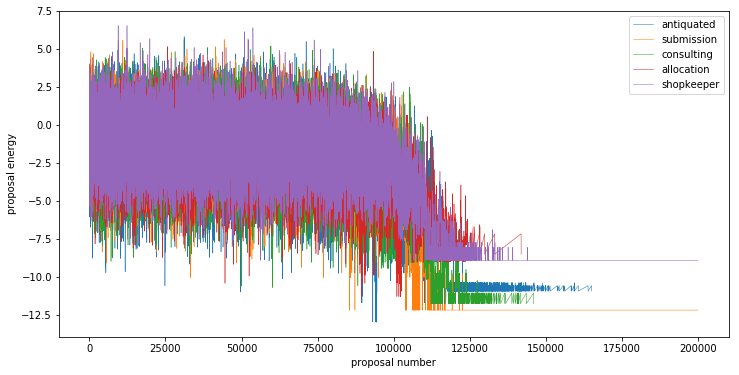

,word,energy,anagram,energy,answer,energy
0,antiquated,-12.952297,tqeiutdaan,0.094032,antiquated,-12.952297
1,submission,-12.171518,iosumisbsn,0.337162,submission,-12.171518
2,consulting,-11.747188,cnnitgulso,-0.964849,consulting,-11.747188
3,allocation,-9.194562,ooaanltlci,1.586637,coallation,-11.280581
4,shopkeeper,-5.826653,oerhspeepk,1.823975,pekeershop,-8.900936


In [4]:
def solve_anagram(anagram, max_steps=int(2e5)):

    def propose(anagram, pairs):
        """Propose a new anagram by swapping adjacent letters"""
        pair = pairs[np.random.randint(n-1)]
        proposal = np.array(list(anagram))
        proposal[pair] = proposal[pair][::-1]
        proposal = ''.join(proposal)
        return proposal

    def accept(anagram_energy, proposal_energy, t=1.0):
        """Accept proposed anagram with simulated annealing probability"""
        p = np.exp((anagram_energy - proposal_energy) / t)
        return np.random.uniform() < p

    def temperature(step, max_steps, t_min=1e-2, t_max=1e2):
        """Return temperature given progress to max_steps"""
        return t_max * np.exp(step / float(max_steps) * np.log(t_min / t_max))
    
    # pairs of neighboring letter indices
    pairs = np.stack([range(n)[:-1], range(n)[1:]]).T

    # initial energy 
    anagram_energy = model.energy(anagram)
    energy_history = [[0, anagram_energy]]
    
    # best guess
    answer = [anagram, anagram_energy]
    
    for step in range(max_steps):
    
        # propose new anagram and compute energy
        proposal = propose(anagram, pairs)
        proposal_energy = model.energy(proposal)
      
        if accept(anagram_energy, proposal_energy, temperature(step, max_steps)):

            # update current guess
            anagram, anagram_energy = proposal, proposal_energy
            energy_history.append([step, anagram_energy])
        
            # record buest guess
            if anagram_energy < answer[1]:
                answer = [anagram, anagram_energy]

    energy_history = np.array(energy_history).T
    return answer, energy_history

tab, e = [], []
# for a random selection of words
for word in np.random.choice(words, size=5, replace=False):
    # make an anagram by permuting the letters in the word
    anagram = ''.join(np.random.permutation(list(word)))
    # solve the anagram with a simulated annealing approach
    answer, energy_history = solve_anagram(anagram)
    tab.append([word, model.energy(word), anagram, model.energy(anagram), answer[0], answer[1]])
    e.append(energy_history)

fig = plt.figure(figsize=(12,6))
ax = plt.gca()
for i, ei in enumerate(e):
    ax.plot(*ei, lw=0.5, label=tab[i][0])
ax.set_xlabel('proposal number')
ax.set_ylabel('proposal energy')
plt.legend()
plt.show()

tab = pd.DataFrame(data=tab, columns=['word', 'energy', 'anagram', 'energy', 'answer', 'energy'])
tab

There are adversarial examples to show the anagram solver. For example, we demonstrate that the search repeatedly guesses "impression" given an anagram of "permission" because the model is in a lower energy state at "impression."

In [5]:
# adversarial examples:
# permission <-> impression
# nonduality <-> undylation
# treatments <-> restatement

word = 'permission'

print 'word: %s, energy: %f' % (word, model.energy(word))

tab = []
for attempt in range(5):
    anagram = ''.join(np.random.permutation(list(word)))
    answer = solve_anagram(anagram)[0]
    tab.append([anagram, model.energy(anagram), answer[0], answer[1]])

tab = pd.DataFrame(data=tab, columns=['anagram', 'energy', 'answer', 'energy'])
tab

word: permission, energy: -10.574511


,anagram,energy,answer,energy
0,emrpoinssi,-1.859870,impression,-13.795883
1,sirspmeoni,-2.762323,impression,-13.795883
2,meriposins,-1.256509,impression,-13.795883
3,oneiirsmsp,-0.925506,impression,-13.795883
4,nismespiro,-0.899383,impression,-13.795883
